[*********************100%***********************]  1 of 1 completed

Calculating Gann levels...
Data shape: (3269, 9)
Date range: 2011-01-04 00:00:00 to 2023-12-29 00:00:00
Column types:
 Open           float64
High           float64
Low            float64
Close          float64
GannRes        float64
GannSup        float64
GannRes_rel    float64
GannSup_rel    float64
Returns        float64
dtype: object

Sample Gann Level Calculations:
Date: 2011-01-04, Price: $14.91, Support: $13.04, Resistance: $16.90
Date: 2017-07-03, Price: $44.67, Support: $41.39, Resistance: $48.07
Date: 2023-12-29, Price: $140.10, Support: $134.24, Resistance: $146.08

Starting walk-forward test with Gann features...
Train period: 6 months (126 days)
Test period: 1 months (21 days)

--- Period 1 ---
Train: 2011-01-04 to 2011-07-05
Test: 2011-07-06 to 2011-08-03
Training agent...


Episode 0/50, Reward: 0.0366, Epsilon: 0.995
Episode 10/50, Reward: -0.0116, Epsilon: 0.946
Episode 20/50, Reward: -0.1114, Epsilon: 0.900
Episode 30/50, Reward: 0.0945, Epsilon: 0.856
Episode 40/50, Reward: 0.1700, Epsilon: 0.814
Test profit: 0.0261
Number of trades: 3

--- Period 2 ---
Train: 2011-02-03 to 2011-08-03
Test: 2011-08-04 to 2011-09-01
Training agent...
Episode 0/50, Reward: -0.1027, Epsilon: 0.995
Episode 10/50, Reward: 0.1037, Epsilon: 0.946
Episode 20/50, Reward: 0.1656, Epsilon: 0.900
Episode 30/50, Reward: 0.3650, Epsilon: 0.856
Episode 40/50, Reward: -0.0018, Epsilon: 0.814
Test profit: 0.0518
Number of trades: 4

--- Period 3 ---
Train: 2011-03-07 to 2011-09-01
Test: 2011-09-02 to 2011-10-03
Training agent...
Episode 0/50, Reward: -0.1394, Epsilon: 0.995
Episode 10/50, Reward: -0.3640, Epsilon: 0.946
Episode 20/50, Reward: 0.4648, Epsilon: 0.900
Episode 30/50, Reward: 0.1383, Epsilon: 0.856
Episode 40/50, Reward: -0.1358, Epsilon: 0.814
Test profit: -0.0251
Number 

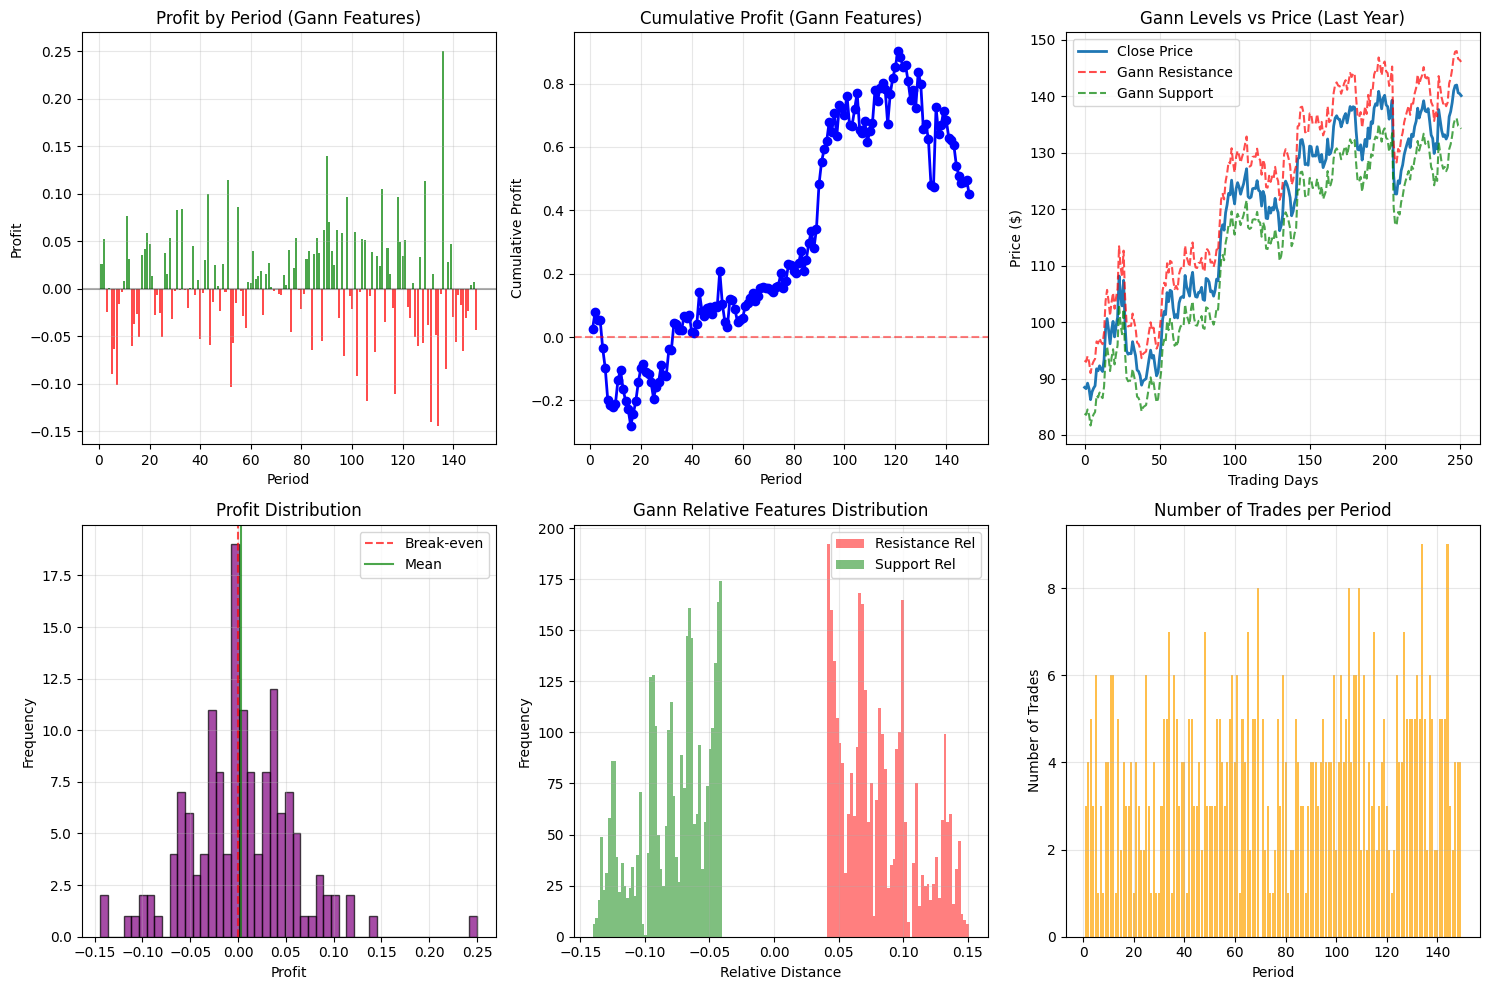


✅ Results saved: results_gann_square_detailed.csv and results_gann_square_summary.csv

Detailed results chart saved as 'gann_trading_detailed_results.png'

Gann Feature Statistics:
Average Resistance Distance: 0.0817
Average Support Distance: -0.0781
Resistance Distance Std: 0.0297
Support Distance Std: 0.0273


In [ ]:
# -----------------------------
# Deep Q-Learning Trading Agent
# OHLC + Gann Support/Resistance Features (Corrected)
# -----------------------------
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# -----------------------------
# Config
# -----------------------------
TICKER = "GOOG"
START_DATE = "2011-01-01"
END_DATE = "2023-12-31"
STATE_WINDOW = 10
TRAIN_MONTHS = 6
TEST_MONTHS = 1
EPISODES = 50
BATCH_SIZE = 32
LR = 0.001
GAMMA = 0.95
EPSILON_START = 1.0
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.995
MEMORY_SIZE = 10000
TARGET_UPDATE = 10

# -----------------------------
# Helper: Gann level calculation
# -----------------------------
def gann_levels(price: float):
    """Calculate Gann Square of Nine resistance and support."""
    if price <= 0:
        return price, price
    root = math.sqrt(price)
    resistance = (root + 0.25) ** 2
    support = max(0, (root - 0.25) ** 2)  # Ensure non-negative
    return resistance, support

# -----------------------------
# Download and Prepare Data
# -----------------------------
print("Downloading data...")
df = yf.download(TICKER, start=START_DATE, end=END_DATE)

# Flatten MultiIndex columns if present
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [col[0] for col in df.columns]

# Keep OHLC only and make a copy
df = df[['Open', 'High', 'Low', 'Close']].copy()

# Force numeric and drop NaN rows
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.dropna(inplace=True)

# --- GANN FEATURES ---
print("Calculating Gann levels...")
gann_res, gann_sup = [], []
for price in df['Close']:
    res, sup = gann_levels(float(price))
    gann_res.append(res)
    gann_sup.append(sup)

df['GannRes'] = gann_res
df['GannSup'] = gann_sup

# Relative distances to current price
df['GannRes_rel'] = (df['GannRes'] - df['Close']) / df['Close']
df['GannSup_rel'] = (df['GannSup'] - df['Close']) / df['Close']

# Returns for optional metrics
df['Returns'] = df['Close'].pct_change()
df.dropna(inplace=True)

print(f"Data shape: {df.shape}")
print(f"Date range: {df.index[0]} to {df.index[-1]}")
print("Column types:\n", df.dtypes)

# Show sample Gann calculations
print("\nSample Gann Level Calculations:")
for i in [0, len(df)//2, -1]:
    price = df['Close'].iloc[i]
    res, sup = gann_levels(price)
    print(f"Date: {df.index[i].strftime('%Y-%m-%d')}, Price: ${price:.2f}, Support: ${sup:.2f}, Resistance: ${res:.2f}")

# -----------------------------
# Trading Environment
# -----------------------------
class TradingEnv:
    def __init__(self, data, window=STATE_WINDOW):
        self.data = data
        self.window = window
        self.reset()

    def reset(self):
        self.current_step = self.window
        self.position = 0  # 0 = flat, 1 = long, -1 = short
        self.entry_price = 0.0
        self.total_profit = 0.0
        self.trades = []
        return self._get_state()

    def _get_state(self):
        if self.current_step >= len(self.data):
            return np.zeros(self.window * 6 + 1)  # 6 features: OHLC + 2 Gann

        features = self.data[['Open', 'High', 'Low', 'Close',
                               'GannRes_rel', 'GannSup_rel']] \
                    .iloc[self.current_step - self.window:self.current_step].values

        # Normalize features (z-score per window)
        norm = (features - np.mean(features, axis=0)) / (np.std(features, axis=0) + 1e-8)
        state = norm.flatten()
        state = np.append(state, self.position)
        return state

    def step(self, action):
        if self.current_step >= len(self.data):
            return self._get_state(), 0.0, True

        reward = 0.0
        current_price = float(self.data.iloc[self.current_step]['Close'])
        transaction_cost = 0.001

        # Action 0: Hold, Action 1: Buy, Action 2: Sell
        if action == 1:  # Buy
            if self.position == 0:  # Enter long
                self.position = 1
                self.entry_price = current_price
                reward = -transaction_cost
            elif self.position == -1:  # Close short, enter long
                profit = (self.entry_price - current_price) / self.entry_price
                reward = profit - transaction_cost
                self.total_profit += reward
                self.trades.append(('close_short', profit))
                self.position = 1
                self.entry_price = current_price

        elif action == 2:  # Sell
            if self.position == 0:  # Enter short
                self.position = -1
                self.entry_price = current_price
                reward = -transaction_cost
            elif self.position == 1:  # Close long, enter short
                profit = (current_price - self.entry_price) / self.entry_price
                reward = profit - transaction_cost
                self.total_profit += reward
                self.trades.append(('close_long', profit))
                self.position = -1
                self.entry_price = current_price

        elif action == 0:  # Hold
            if self.position == 1:  # Long position
                unrealized_pnl = (current_price - self.entry_price) / self.entry_price
                reward = unrealized_pnl * 0.1  # Small reward for unrealized gains
            elif self.position == -1:  # Short position
                unrealized_pnl = (self.entry_price - current_price) / self.entry_price
                reward = unrealized_pnl * 0.1  # Small reward for unrealized gains
            else:
                reward = 0.0  # No position, no reward

        self.current_step += 1
        done = self.current_step >= len(self.data)

        # Close position if episode is done
        if done and self.position != 0:
            if self.position == 1:
                final_profit = (current_price - self.entry_price) / self.entry_price
                self.trades.append(('final_close_long', final_profit))
            else:
                final_profit = (self.entry_price - current_price) / self.entry_price
                self.trades.append(('final_close_short', final_profit))
            self.total_profit += final_profit

        return self._get_state(), float(reward), done

# -----------------------------
# DQN Model
# -----------------------------
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

# -----------------------------
# Replay Buffer
# -----------------------------
class ReplayBuffer:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# -----------------------------
# Train Agent
# -----------------------------
def train_agent(train_data):
    state_dim = STATE_WINDOW * 6 + 1  # 6 features (OHLC + 2 Gann) + position
    action_dim = 3
    env = TradingEnv(train_data)

    policy_net = DQN(state_dim, action_dim)
    target_net = DQN(state_dim, action_dim)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=LR)
    memory = ReplayBuffer(MEMORY_SIZE)

    epsilon = EPSILON_START
    episode_rewards = []

    print("Training agent...")
    for ep in range(EPISODES):
        state = env.reset()
        episode_reward = 0.0
        done = False

        while not done:
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = random.randrange(action_dim)
            else:
                with torch.no_grad():
                    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                    q_values = policy_net(state_tensor)
                    action = torch.argmax(q_values).item()

            next_state, reward, done = env.step(action)
            memory.push(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward

            # Train the network
            if len(memory) >= BATCH_SIZE:
                batch = memory.sample(BATCH_SIZE)
                states, actions, rewards, next_states, dones = zip(*batch)

                # Convert to tensors with proper handling
                states = torch.tensor(np.array(states), dtype=torch.float32)
                actions = torch.tensor(np.array(actions), dtype=torch.int64).unsqueeze(1)
                rewards = torch.tensor(np.array(rewards, dtype=np.float32), dtype=torch.float32).unsqueeze(1)
                next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
                dones = torch.tensor(np.array(dones, dtype=np.float32), dtype=torch.float32).unsqueeze(1)

                # Q-learning update
                current_q_values = policy_net(states).gather(1, actions)
                next_q_values = target_net(next_states).max(1)[0].unsqueeze(1)
                target_q_values = rewards + (GAMMA * next_q_values * (1 - dones))

                # Compute loss and update
                loss = nn.MSELoss()(current_q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)  # Gradient clipping
                optimizer.step()

        episode_rewards.append(episode_reward)
        epsilon = max(EPSILON_MIN, epsilon * EPSILON_DECAY)

        # Update target network
        if ep % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if ep % 10 == 0:
            print(f"Episode {ep}/{EPISODES}, Reward: {episode_reward:.4f}, Epsilon: {epsilon:.3f}")

    return policy_net, episode_rewards

# -----------------------------
# Test Agent
# -----------------------------
def test_agent(test_data, trained_model):
    env = TradingEnv(test_data)
    state = env.reset()
    done = False
    actions_taken = []

    while not done:
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            q_values = trained_model(state_tensor)
            action = torch.argmax(q_values).item()

        actions_taken.append(action)
        next_state, reward, done = env.step(action)
        state = next_state

    # Ensure scalar return values
    total_profit = float(env.total_profit)
    num_trades = int(len(env.trades))

    return total_profit, num_trades, actions_taken

# -----------------------------
# Walk-Forward Testing
# -----------------------------
def run_walk_forward_test():
    results = []
    start_idx = 0
    period = 0

    days_per_month = 21
    train_days = TRAIN_MONTHS * days_per_month
    test_days = TEST_MONTHS * days_per_month

    print(f"\nStarting walk-forward test with Gann features...")
    print(f"Train period: {TRAIN_MONTHS} months ({train_days} days)")
    print(f"Test period: {TEST_MONTHS} months ({test_days} days)")

    while True:
        train_end_idx = start_idx + train_days
        test_end_idx = train_end_idx + test_days

        if test_end_idx >= len(df):
            break

        period += 1
        train_data = df.iloc[start_idx:train_end_idx].copy()
        test_data = df.iloc[train_end_idx:test_end_idx].copy()

        print(f"\n--- Period {period} ---")
        print(f"Train: {train_data.index[0].strftime('%Y-%m-%d')} to {train_data.index[-1].strftime('%Y-%m-%d')}")
        print(f"Test: {test_data.index[0].strftime('%Y-%m-%d')} to {test_data.index[-1].strftime('%Y-%m-%d')}")

        model, training_rewards = train_agent(train_data)
        profit, num_trades, actions = test_agent(test_data, model)

        results.append({
            'period': period,
            'profit': profit,
            'num_trades': num_trades,
            'train_start': train_data.index[0],
            'train_end': train_data.index[-1],
            'test_start': test_data.index[0],
            'test_end': test_data.index[-1]
        })

        print(f"Test profit: {profit:.4f}")
        print(f"Number of trades: {num_trades}")

        # Move to next period
        start_idx += test_days

    return results
import os

def save_results_to_csv(results, filename="results_gann_square.csv"):
    df_results = pd.DataFrame(results)

    # Compute summary statistics
    profits = [r['profit'] for r in results]
    total_profit = sum(profits)
    avg_profit = np.mean(profits)
    win_rate = len([p for p in profits if p > 0]) / len(profits) * 100
    best = max(profits)
    worst = min(profits)

    summary = {
        "total_periods": len(results),
        "total_profit": total_profit,
        "avg_profit": avg_profit,
        "win_rate": win_rate,
        "best_period": best,
        "worst_period": worst
    }

    # Save to CSV
    os.makedirs("results", exist_ok=True)
    summary_df = pd.DataFrame([summary])

    # Save detailed and summary
    df_results.to_csv(os.path.join("results", filename.replace(".csv", "_detailed.csv")), index=False)
    summary_df.to_csv(os.path.join("results", filename.replace(".csv", "_summary.csv")), index=False)

    print(f"\n✅ Results saved: {filename.replace('.csv','_detailed.csv')} and {filename.replace('.csv','_summary.csv')}")

# -----------------------------
# Main Execution
# -----------------------------
if __name__ == "__main__":
    # Run the walk-forward test
    results = run_walk_forward_test()

    # Print summary results
    print("\n" + "="*60)
    print("WALK-FORWARD TEST RESULTS (WITH GANN FEATURES)")
    print("="*60)

    total_profit = 0
    total_trades = 0

    for result in results:
        print(f"Period {result['period']}: Profit = {result['profit']:.4f}, Trades = {result['num_trades']}")
        total_profit += result['profit']
        total_trades += result['num_trades']

    print(f"\nSUMMARY:")
    print(f"Total periods: {len(results)}")
    print(f"Total profit: {total_profit:.4f}")
    print(f"Average profit per period: {total_profit/len(results):.4f}")
    print(f"Total trades: {total_trades}")
    print(f"Average trades per period: {total_trades/len(results):.1f}")

    # Calculate basic statistics
    profits = [r['profit'] for r in results]
    win_rate = len([p for p in profits if p > 0]) / len(profits) * 100
    print(f"Win rate: {win_rate:.1f}%")
    print(f"Best period: {max(profits):.4f}")
    print(f"Worst period: {min(profits):.4f}")

    # Visualize results
    periods = [r['period'] for r in results]
    cumulative_profit = np.cumsum(profits)

    plt.figure(figsize=(15, 10))

    # Plot 1: Individual period profits
    plt.subplot(2, 3, 1)
    colors = ['green' if p > 0 else 'red' for p in profits]
    plt.bar(periods, profits, color=colors, alpha=0.7)
    plt.title('Profit by Period (Gann Features)')
    plt.xlabel('Period')
    plt.ylabel('Profit')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.grid(True, alpha=0.3)

    # Plot 2: Cumulative profit
    plt.subplot(2, 3, 2)
    plt.plot(periods, cumulative_profit, marker='o', linewidth=2, color='blue')
    plt.title('Cumulative Profit (Gann Features)')
    plt.xlabel('Period')
    plt.ylabel('Cumulative Profit')
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    plt.grid(True, alpha=0.3)

    # Plot 3: Sample Gann levels vs Price
    sample_data = df.iloc[-252:].copy()  # Last year
    plt.subplot(2, 3, 3)
    plt.plot(range(len(sample_data)), sample_data['Close'].values, label='Close Price', linewidth=2)
    plt.plot(range(len(sample_data)), sample_data['GannRes'].values, label='Gann Resistance',
             alpha=0.7, linestyle='--', color='red')
    plt.plot(range(len(sample_data)), sample_data['GannSup'].values, label='Gann Support',
             alpha=0.7, linestyle='--', color='green')
    plt.title('Gann Levels vs Price (Last Year)')
    plt.xlabel('Trading Days')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 4: Profit distribution
    plt.subplot(2, 3, 4)
    plt.hist(profits, bins=max(3, len(profits)//3), alpha=0.7, color='purple', edgecolor='black')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Break-even')
    plt.axvline(x=np.mean(profits), color='green', linestyle='-', alpha=0.7, label='Mean')
    plt.title('Profit Distribution')
    plt.xlabel('Profit')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 5: Gann relative features distribution
    plt.subplot(2, 3, 5)
    plt.hist(df['GannRes_rel'].values, bins=50, alpha=0.5, label='Resistance Rel', color='red')
    plt.hist(df['GannSup_rel'].values, bins=50, alpha=0.5, label='Support Rel', color='green')
    plt.title('Gann Relative Features Distribution')
    plt.xlabel('Relative Distance')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 6: Number of trades per period
    trades_per_period = [r['num_trades'] for r in results]
    plt.subplot(2, 3, 6)
    plt.bar(periods, trades_per_period, alpha=0.7, color='orange')
    plt.title('Number of Trades per Period')
    plt.xlabel('Period')
    plt.ylabel('Number of Trades')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('gann_trading_detailed_results.png', dpi=150, bbox_inches='tight')
    plt.show()

    save_results_to_csv(results, filename="results_gann_square.csv")

    print(f"\nDetailed results chart saved as 'gann_trading_detailed_results.png'")

    # Show final Gann statistics
    print(f"\nGann Feature Statistics:")
    print(f"Average Resistance Distance: {df['GannRes_rel'].mean():.4f}")
    print(f"Average Support Distance: {df['GannSup_rel'].mean():.4f}")
    print(f"Resistance Distance Std: {df['GannRes_rel'].std():.4f}")
    print(f"Support Distance Std: {df['GannSup_rel'].std():.4f}")